Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])


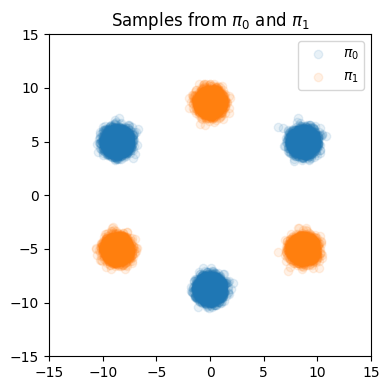

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F



D = 10.
M = D+5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

plt.figure(figsize=(4,4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()




In [ ]:
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x
    
class MLP_2nd_order(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + input_dim + 1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, first_order_input, x_input, t):
        inputs = torch.cat([first_order_input, x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x
    

class RectifiedFlow():
  def __init__(self, first_order_model=None, second_order_model=None, num_steps=1000):
    # self.model = model
    self.first_order_model = first_order_model
    self.second_order_model = second_order_model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):

    # assert False, "Zhizhou: Modified this function, let it return second order before you call it"

    t = torch.rand((z1.shape[0], 1))
    a = 19.9
    b = 0.1

    # alpha_t = e^{(-1/4 a (1-t)^2-1/2 b(1-t))}
    alpha_t = torch.exp(- (1/4) * a * (1-t)**2 - (1/2) * b * (1-t))

    # first order alpha: 
    # d alpha_t / dt = alpha_t * 1/2 * (a (1-t) + b)
    first_oreder_alpha = alpha_t * (1/2) * (a * (1-t) + b)

    # second order alpha:
    # d^2 alpha_t / dt^2 = 1/2 * (alpha_t * (a(1-x)+b)^2 - a alpha_t)
    second_order_alpha = (1/2) * (alpha_t * (a * (1-t) + b)**2 - a * alpha_t)

    # beta_t = sqrt{1-alpha^2}
    beta_t = torch.sqrt(1 - alpha_t**2)
    # first order beta
    # d beta_t / dt = (- alpha  / sqrt{1 - alpha^2}) * (d alpha / dt)
    first_order_beta = (- alpha_t / torch.sqrt(1 - alpha_t**2)) * first_oreder_alpha
    # second order beta
    # d^2 beta_t / dt^2 = (- 1  / (1 - alpha^2) sqrt (1 - x^2)) * (d alpha / dt) + (- alpha  / sqrt{1 - alpha^2}) * (d^2 alpha / dt^2)
    second_order_beta = (- 1 / ((1 - alpha_t**2) * torch.sqrt(1 - alpha_t**2))) * first_oreder_alpha + first_order_beta * second_order_alpha

    # print(type(alpha_t))
    # print(alpha_t.shape)
    # print(alpha_t)
    # print(first_oreder_alpha)
    # print(second_order_alpha)
    # print(beta_t)
    # print(first_order_beta)
    # print(second_order_beta)
    # raise

    z_t = alpha_t * z1 + beta_t * z0
    first_order_gt = first_oreder_alpha * z1 + first_order_beta * z0
    second_order_gt = second_order_alpha * z1 + second_order_beta * z0

    return z_t, t, first_order_gt, second_order_gt

    # z_t =  t * z1 + (1.-t) * z0
    # target = z1 - z0

    # return z_t, t, target
  
  def frist_and_second_order_predict(self, z_t, t):
    first_order_pred = self.first_order_model(z_t, t)
    second_order_pred = self.second_order_model(first_order_pred, z_t, t)
    return first_order_pred, second_order_pred

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):

    # assert False, "Zhizhou: Modified the sample ode fruntion before you call it"

    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
    #   pred = self.model(z, t)
      first_order_pred, second_order_pred = self.frist_and_second_order_predict(z, t)
    #   z = z.detach().clone() + pred * dt
      z = z.detach().clone() + first_order_pred * dt + 0.5 * second_order_pred * dt**2

      traj.append(z.detach().clone())

    return traj
  
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in tqdm(range(inner_iters+1)):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()

    # z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    z_t, t, first_order_gt, second_order_gt = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    # zt shape: [bs, 2]
    # t shape: [bs, 1]

    # print(z_t.shape)
    # print(t.shape)
    # raise

    # pred = rectified_flow.model(z_t, t)

    first_order_pred, second_order_pred = rectified_flow.frist_and_second_order_predict(z_t, t)

    first_order_loss = (first_order_gt - first_order_pred).abs().pow(2).sum(dim=1)
    second_order_loss = (second_order_gt - second_order_pred).abs().pow(2).sum(dim=1)
    loss = first_order_loss + second_order_loss
    loss = loss.mean()
    loss.backward()

    # loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    # loss = loss.mean()
    # loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


# generate training data
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)
print(x_pairs.shape)


# training code start
iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(first_order_model=MLP(input_dim, hidden_num=100), second_order_model=MLP_2nd_order(input_dim, hidden_num=100), num_steps=100)
# change the parameter list to all model parameters
rectified_flow_model_parameters = list(rectified_flow_1.first_order_model.parameters()) + list(rectified_flow_1.second_order_model.parameters())
optimizer = torch.optim.Adam(rectified_flow_model_parameters, lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')


torch.Size([10000, 2, 2])


  0%|          | 0/10001 [00:00<?, ?it/s]

tensor([[0.3478],
        [0.0503],
        [0.2310],
        ...,
        [0.9446],
        [0.0150],
        [0.9569]])
tensor([[1.5945],
        [0.3877],
        [1.2476],
        ...,
        [1.0073],
        [0.1373],
        [0.8977]])
tensor([[11.1608],
        [ 5.4821],
        [11.1751],
        ...,
        [-7.2502],
        [ 2.3610],
        [-7.8362]])
tensor([[0.9376],
        [0.9987],
        [0.9729],
        ...,
        [0.3283],
        [0.9999],
        [0.2906]])
tensor([[-5.9142e-01],
        [-1.9510e-02],
        [-2.9627e-01],
        ...,
        [-2.8982e+00],
        [-2.0638e-03],
        [-2.9561e+00]])
tensor([[ -8.5353],
        [ -0.4961],
        [ -4.6655],
        ...,
        [ -7.4562],
        [ -0.1423],
        [-13.4250]])


RuntimeError: No active exception to reraise

In [ ]:
@torch.no_grad()
def sample_ode_with_model(rectflow_model, z0=None, N=None):

  # assert False, "Zhizhou: Modified the sample ode fruntion before you call it"

  # ### NOTE: Use Euler method to sample from the learned flow
  # if N is None:
  #   N = self.N
  dt = 1./N
  traj = [] # to store the trajectory
  z = z0.detach().clone()
  batchsize = z.shape[0]

  traj.append(z.detach().clone())
  for i in range(N):
    t = torch.ones((batchsize,1)) * i / N
  #   pred = self.model(z, t)
    first_order_pred, second_order_pred = rectflow_model.frist_and_second_order_predict(z, t)

    # first order and second order here are already nan

    # print(first_order_pred)
    # print(second_order_pred)
    # raise

    # first_order_pred, second_order_pred = self.frist_and_second_order_predict(z, t)
  #   z = z.detach().clone() + pred * dt
    z = z.detach().clone() + first_order_pred * dt + 0.5 * second_order_pred * dt**2

    traj.append(z.detach().clone())

  return traj


@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  # traj = rectified_flow.sample_ode(z0=z0, N=N)
  traj = sample_ode_with_model(rectified_flow, z0=z0, N=N)

#   print(len(traj))

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

#   print(traj[0][:, 1].cpu().numpy())
#   raise

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]])
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]])


RuntimeError: No active exception to reraise